# Network dynamics of Network FKPP + Atrophy

In the following notebook, I will attempt to simulate data of brain atrophy that is coupled with a reaction-diffusion process of at toxic protein. If successful, I will then build a probablistic model of this using `Turing` to perform Bayesian inference on simulated data.

The model is as follows: 

$\frac{d\mathbf{p}_i}{dt} = -k \sum\limits_{j=1}^{N}\mathbf{L}_{ij}^{\omega}\mathbf{p}_j + \alpha \mathbf{p}_i\left(1-\mathbf{p}_i\right)$

$\frac{d\mathbf{q}_i}{dt} = \beta p_i (1 - q_i)$ 

Where the first equation describes the reaction-diffusion process of prion protein $\mathbf{p}$ and the second equation describes the regional atrophy at a given node $q_i$. 


# Environment

Make sure you are using the correct environment and document the packages used.

In [1]:
using Pkg

In [17]:
using DelimitedFiles
using SparseArrays
using Statistics
using SimpleWeightedGraphs
using LightGraphs
using DifferentialEquations
using Turing
using Plots
using Base.Threads
using BenchmarkTools
using Random

include("../../scripts/Models/Models.jl")
include("../../scripts/Models/Matrices.jl")

diffusive_weight (generic function with 1 method)

In [10]:
Random.seed!(1);

In [12]:
gr()

Plots.GRBackend()

# Model definition 

Firstly, since these are network models, we will first construct a network for the models to exist on. For this, we will use a fully connected weighted graph with 10 nodes.

In [21]:
const csv_path = "/Users/pavanchaggar/Projects/Connectomes/all_subjects"
const subject_dir = "/Users/pavanchaggar/Projects/Connectomes/standard_connectome/scale1/subjects/"

"/Users/pavanchaggar/Projects/Connectomes/standard_connectome/scale1/subjects/"

In [22]:
subjects = read_subjects(csv_path);

In [25]:
An = load_connectome(subjects, subject_dir, 100, 83, false) |> mean_connectome;
Al = load_connectome(subjects, subject_dir, 100, 83, true) |> mean_connectome;

In [26]:
A = diffusive_weight(An, Al) |> max_norm
L = laplacian(A);

In [27]:
function NetworkAtrophyODE(du, u0, p, t)
    n = Int(length(u0)/2)

    x = u0[1:n]
    y = u0[n+1:2n]

    κ, α, β = p

    du[1:n] .= -κ * L * x .+ α .* x .* (1.0 .- x)
    du[n+1:2n] .= β * x .* (1.0 .- y)
end

NetworkAtrophyODE (generic function with 1 method)

In [29]:
p = [2.5, 1.0, 0.4]
protein = zeros(83)
protein[[27,68]] .= 0.1;
u0 = [protein; zeros(83)];
t_span = (0.0, 10.0);

problem = ODEProblem(NetworkAtrophyODE, u0, t_span, p)


sol = solve(problem, Tsit5(), saveat=2.0)
fullsol = solve(problem, Tsit5(), saveat=0.1);

In [30]:
data = clamp.(Array(sol) + 0.02 * randn(size(Array(sol))), 0.0,1.0)

atrophy_data = data[84:end,:];

## Inference

In [31]:
@model function NetworkAtrophyPM(data, problem)
    σ ~ InverseGamma(2, 3)	
	
    k ~ truncated(Normal(0, 1), 0, 5)
	a ~ truncated(Normal(0, 5), 0, 10)
    b ~ truncated(Normal(0, 5), 0, 10)

    p = [k, a, b]

    prob = remake(problem, p=p)
    
    predicted = solve(prob, Tsit5(), saveat=2.0)

    data ~ arraydist(Normal.(predicted[84:end,:], σ))
end

NetworkAtrophyPM (generic function with 1 method)

In [33]:
model = NetworkAtrophyPM(atrophy_data, problem);

In [35]:
model();

In [36]:
function plot_predictive(chain, prob, sol, data; N=200, node=27) 
	plot(sol, vars=(node), w=2, legend = false)
    for i in 1:N
        resol = solve(remake(prob, 
                             p=[chain[:k][i], 
                                chain[:a][i], 
                                chain[:b][i]]),
                             Tsit5(),
                             saveat=0.5)
        plot!(resol, vars=(node), alpha=0.1, color=:grey,legend=false)
	end
    scatter!(sol.t, data[node,:], legend = false)
end

plot_predictive (generic function with 1 method)

In [37]:
prior_chain = sample(model, Prior(), 1_000)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03


Chains MCMC chain (1000×5×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.88 seconds
Compute duration  = 5.88 seconds
parameters        = a, b, σ, k
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    2.9714    4.4768     0.1416    0.1492   994.4926    0.9992     ⋯
           k    0.8150    0.6206     0.0196    0.0177   986.9843    1.0006     ⋯
           a    3.7123    2.4894     0.0787    0.0781   956.7681    1.0004     ⋯
           b    3.6073    2.5476     0.0806    0.0911   912.4844    0.9990     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ    0.5572    1

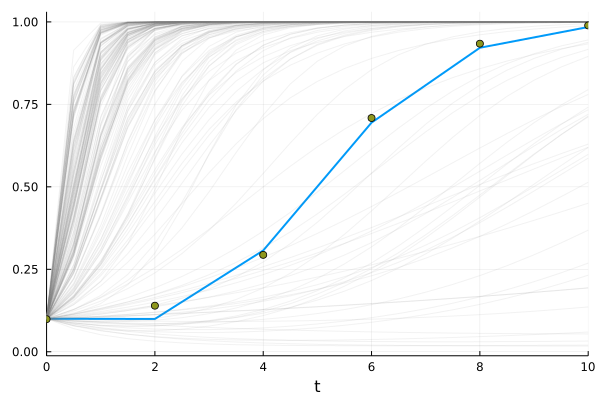

In [38]:
plot_predictive(prior_chain, problem, sol, data)

In [39]:
chain = sample(model, NUTS(0.65), 1_000)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /Users/pavanchaggar/.julia/packages/Turing/YGtAo/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:02:29


Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 164.54 seconds
Compute duration  = 164.54 seconds
parameters        = a, b, σ, k
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

           σ    0.0203    0.0007     0.0000    0.0000   625.7059    1.0023     ⋯
           k    2.4428    0.0454     0.0014    0.0015   438.7792    1.0004     ⋯
           a    1.0137    0.0099     0.0003    0.0004   406.3305    1.0011     ⋯
           b    0.3896    0.0070     0.0002    0.0003   441.2693    1.0000     ⋯
                                                            

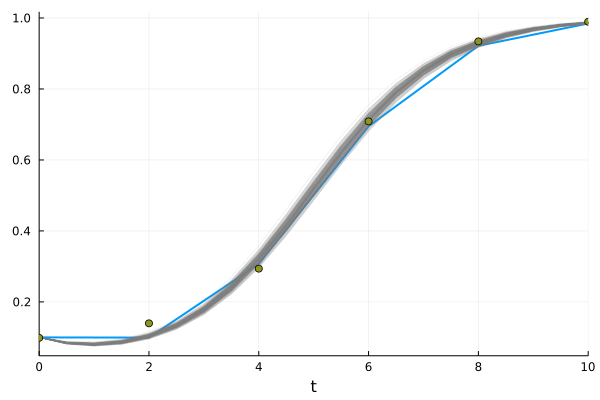

In [40]:
plot_predictive(chain, problem, sol, data; node=27)